# Exploring the SVHN Data

### Importing neccessary libraries

In [1]:

import numpy as np
import scipy.io as sio

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import models
from torchinfo import summary

### Loading the test and training data

In [2]:
train = torchvision.datasets.SVHN(root="data/", split="train", transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.SVHN(root="data/", split="test", transform=torchvision.transforms.ToTensor())

### Preparing out data set

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 3, 32, 32])

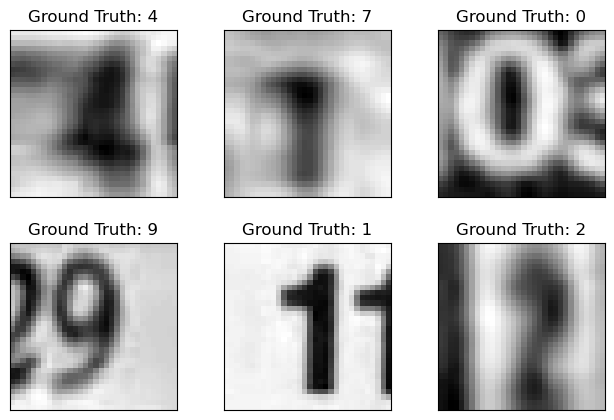

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()

In [44]:
# 3 layer Net (1 convolutional layer, 2 linear layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1960, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv1(x)), 2))
        x = x.view(-1, 1960)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [33]:
# 4 layer Net (2 convolutional layers, 2 linear layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [39]:
# 5 layer Net (3 convolutional layers, 2 linear layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(270, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv2_drop(self.conv3(x)), 2)  # can't pool because image will be too small
        x = x.view(-1, 270)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [45]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


summary(network,(1000, 3, 32, 32))

C:\Users\magma\AppData\Local\Temp\ipykernel_11596\827942670.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1000, 10]                --
├─Conv2d: 1-1                            [1000, 10, 28, 28]        760
├─Dropout2d: 1-2                         [1000, 10, 28, 28]        --
├─Linear: 1-3                            [1000, 50]                98,050
├─Linear: 1-4                            [1000, 10]                510
Total params: 99,320
Trainable params: 99,320
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 694.40
Input size (MB): 12.29
Forward/backward pass size (MB): 63.20
Params size (MB): 0.40
Estimated Total Size (MB): 75.89

In [46]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [47]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [48]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [49]:
print(example_data.shape)
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

torch.Size([1000, 3, 32, 32])


C:\Users\magma\AppData\Local\Temp\ipykernel_11596\827942670.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3143, Accuracy: 2654/26032 (10%)

Train Epoch: 1 [0/73257 (0%)]	Loss: 2.309541
Train Epoch: 1 [640/73257 (1%)]	Loss: 2.283199
Train Epoch: 1 [1280/73257 (2%)]	Loss: 2.285181
Train Epoch: 1 [1920/73257 (3%)]	Loss: 2.295430
Train Epoch: 1 [2560/73257 (3%)]	Loss: 2.329302
Train Epoch: 1 [3200/73257 (4%)]	Loss: 2.194159
Train Epoch: 1 [3840/73257 (5%)]	Loss: 2.214059
Train Epoch: 1 [4480/73257 (6%)]	Loss: 2.226381
Train Epoch: 1 [5120/73257 (7%)]	Loss: 2.270843
Train Epoch: 1 [5760/73257 (8%)]	Loss: 2.261127
Train Epoch: 1 [6400/73257 (9%)]	Loss: 2.242200
Train Epoch: 1 [7040/73257 (10%)]	Loss: 2.311620
Train Epoch: 1 [7680/73257 (10%)]	Loss: 2.325858
Train Epoch: 1 [8320/73257 (11%)]	Loss: 2.294762
Train Epoch: 1 [8960/73257 (12%)]	Loss: 2.262745
Train Epoch: 1 [9600/73257 (13%)]	Loss: 2.255830
Train Epoch: 1 [10240/73257 (14%)]	Loss: 2.248249
Train Epoch: 1 [10880/73257 (15%)]	Loss: 2.272874
Train Epoch: 1 [11520/73257 (16%)]	Loss: 2.221862
Train Epoch: 1 [12160/7

Train Epoch: 2 [30720/73257 (42%)]	Loss: 2.185423
Train Epoch: 2 [31360/73257 (43%)]	Loss: 2.307956
Train Epoch: 2 [32000/73257 (44%)]	Loss: 2.238878
Train Epoch: 2 [32640/73257 (45%)]	Loss: 2.234984
Train Epoch: 2 [33280/73257 (45%)]	Loss: 2.224485
Train Epoch: 2 [33920/73257 (46%)]	Loss: 2.177300
Train Epoch: 2 [34560/73257 (47%)]	Loss: 2.269618
Train Epoch: 2 [35200/73257 (48%)]	Loss: 2.259630
Train Epoch: 2 [35840/73257 (49%)]	Loss: 2.200122
Train Epoch: 2 [36480/73257 (50%)]	Loss: 2.235709
Train Epoch: 2 [37120/73257 (51%)]	Loss: 2.186256
Train Epoch: 2 [37760/73257 (52%)]	Loss: 2.148322
Train Epoch: 2 [38400/73257 (52%)]	Loss: 2.226423
Train Epoch: 2 [39040/73257 (53%)]	Loss: 2.186980
Train Epoch: 2 [39680/73257 (54%)]	Loss: 2.126854
Train Epoch: 2 [40320/73257 (55%)]	Loss: 2.207754
Train Epoch: 2 [40960/73257 (56%)]	Loss: 2.192186
Train Epoch: 2 [41600/73257 (57%)]	Loss: 2.114563
Train Epoch: 2 [42240/73257 (58%)]	Loss: 2.247179
Train Epoch: 2 [42880/73257 (59%)]	Loss: 2.224843


Train Epoch: 3 [62720/73257 (86%)]	Loss: 1.756781
Train Epoch: 3 [63360/73257 (86%)]	Loss: 1.879145
Train Epoch: 3 [64000/73257 (87%)]	Loss: 1.858253
Train Epoch: 3 [64640/73257 (88%)]	Loss: 1.861158
Train Epoch: 3 [65280/73257 (89%)]	Loss: 1.886886
Train Epoch: 3 [65920/73257 (90%)]	Loss: 1.831398
Train Epoch: 3 [66560/73257 (91%)]	Loss: 1.885645
Train Epoch: 3 [67200/73257 (92%)]	Loss: 1.936021
Train Epoch: 3 [67840/73257 (93%)]	Loss: 1.939143
Train Epoch: 3 [68480/73257 (93%)]	Loss: 1.899762
Train Epoch: 3 [69120/73257 (94%)]	Loss: 2.062641
Train Epoch: 3 [69760/73257 (95%)]	Loss: 1.922490
Train Epoch: 3 [70400/73257 (96%)]	Loss: 1.796277
Train Epoch: 3 [71040/73257 (97%)]	Loss: 1.897522
Train Epoch: 3 [71680/73257 (98%)]	Loss: 1.913166
Train Epoch: 3 [72320/73257 (99%)]	Loss: 1.982618
Train Epoch: 3 [72960/73257 (100%)]	Loss: 1.987030

Test set: Avg. loss: 1.6378, Accuracy: 13542/26032 (52%)

Train Epoch: 4 [0/73257 (0%)]	Loss: 1.772781
Train Epoch: 4 [640/73257 (1%)]	Loss: 1.72014

Train Epoch: 5 [20480/73257 (28%)]	Loss: 1.774175
Train Epoch: 5 [21120/73257 (29%)]	Loss: 1.670652
Train Epoch: 5 [21760/73257 (30%)]	Loss: 1.690911
Train Epoch: 5 [22400/73257 (31%)]	Loss: 1.728187
Train Epoch: 5 [23040/73257 (31%)]	Loss: 1.445903
Train Epoch: 5 [23680/73257 (32%)]	Loss: 1.578787
Train Epoch: 5 [24320/73257 (33%)]	Loss: 1.650176
Train Epoch: 5 [24960/73257 (34%)]	Loss: 1.618363
Train Epoch: 5 [25600/73257 (35%)]	Loss: 1.640432
Train Epoch: 5 [26240/73257 (36%)]	Loss: 1.562672
Train Epoch: 5 [26880/73257 (37%)]	Loss: 1.936614
Train Epoch: 5 [27520/73257 (38%)]	Loss: 1.531458
Train Epoch: 5 [28160/73257 (38%)]	Loss: 1.863817
Train Epoch: 5 [28800/73257 (39%)]	Loss: 1.701064
Train Epoch: 5 [29440/73257 (40%)]	Loss: 1.632941
Train Epoch: 5 [30080/73257 (41%)]	Loss: 1.612327
Train Epoch: 5 [30720/73257 (42%)]	Loss: 1.795965
Train Epoch: 5 [31360/73257 (43%)]	Loss: 1.698205
Train Epoch: 5 [32000/73257 (44%)]	Loss: 1.630956
Train Epoch: 5 [32640/73257 (45%)]	Loss: 1.823331


Train Epoch: 6 [52480/73257 (72%)]	Loss: 1.577762
Train Epoch: 6 [53120/73257 (72%)]	Loss: 1.508644
Train Epoch: 6 [53760/73257 (73%)]	Loss: 1.511584
Train Epoch: 6 [54400/73257 (74%)]	Loss: 1.476077
Train Epoch: 6 [55040/73257 (75%)]	Loss: 1.394696
Train Epoch: 6 [55680/73257 (76%)]	Loss: 1.321824
Train Epoch: 6 [56320/73257 (77%)]	Loss: 1.608953
Train Epoch: 6 [56960/73257 (78%)]	Loss: 1.710610
Train Epoch: 6 [57600/73257 (79%)]	Loss: 1.421273
Train Epoch: 6 [58240/73257 (79%)]	Loss: 1.471298
Train Epoch: 6 [58880/73257 (80%)]	Loss: 1.446225
Train Epoch: 6 [59520/73257 (81%)]	Loss: 1.453231
Train Epoch: 6 [60160/73257 (82%)]	Loss: 1.511827
Train Epoch: 6 [60800/73257 (83%)]	Loss: 1.609073
Train Epoch: 6 [61440/73257 (84%)]	Loss: 1.686645
Train Epoch: 6 [62080/73257 (85%)]	Loss: 1.534789
Train Epoch: 6 [62720/73257 (86%)]	Loss: 1.719418
Train Epoch: 6 [63360/73257 (86%)]	Loss: 1.476249
Train Epoch: 6 [64000/73257 (87%)]	Loss: 1.513545
Train Epoch: 6 [64640/73257 (88%)]	Loss: 1.648372


Train Epoch: 8 [10240/73257 (14%)]	Loss: 1.532334
Train Epoch: 8 [10880/73257 (15%)]	Loss: 1.359036
Train Epoch: 8 [11520/73257 (16%)]	Loss: 1.360614
Train Epoch: 8 [12160/73257 (17%)]	Loss: 1.528251
Train Epoch: 8 [12800/73257 (17%)]	Loss: 1.453344
Train Epoch: 8 [13440/73257 (18%)]	Loss: 1.635786
Train Epoch: 8 [14080/73257 (19%)]	Loss: 1.342153
Train Epoch: 8 [14720/73257 (20%)]	Loss: 1.677108
Train Epoch: 8 [15360/73257 (21%)]	Loss: 1.545436
Train Epoch: 8 [16000/73257 (22%)]	Loss: 1.535554
Train Epoch: 8 [16640/73257 (23%)]	Loss: 1.761302
Train Epoch: 8 [17280/73257 (24%)]	Loss: 1.538947
Train Epoch: 8 [17920/73257 (24%)]	Loss: 1.618257
Train Epoch: 8 [18560/73257 (25%)]	Loss: 1.359167
Train Epoch: 8 [19200/73257 (26%)]	Loss: 1.304175
Train Epoch: 8 [19840/73257 (27%)]	Loss: 1.575589
Train Epoch: 8 [20480/73257 (28%)]	Loss: 1.479924
Train Epoch: 8 [21120/73257 (29%)]	Loss: 1.471464
Train Epoch: 8 [21760/73257 (30%)]	Loss: 1.497920
Train Epoch: 8 [22400/73257 (31%)]	Loss: 1.216008


Train Epoch: 9 [42240/73257 (58%)]	Loss: 1.623165
Train Epoch: 9 [42880/73257 (59%)]	Loss: 1.551188
Train Epoch: 9 [43520/73257 (59%)]	Loss: 1.569732
Train Epoch: 9 [44160/73257 (60%)]	Loss: 1.634098
Train Epoch: 9 [44800/73257 (61%)]	Loss: 1.371139
Train Epoch: 9 [45440/73257 (62%)]	Loss: 1.459803
Train Epoch: 9 [46080/73257 (63%)]	Loss: 1.144187
Train Epoch: 9 [46720/73257 (64%)]	Loss: 1.566991
Train Epoch: 9 [47360/73257 (65%)]	Loss: 1.465243
Train Epoch: 9 [48000/73257 (66%)]	Loss: 1.264174
Train Epoch: 9 [48640/73257 (66%)]	Loss: 1.667283
Train Epoch: 9 [49280/73257 (67%)]	Loss: 1.661525
Train Epoch: 9 [49920/73257 (68%)]	Loss: 1.493042
Train Epoch: 9 [50560/73257 (69%)]	Loss: 1.534084
Train Epoch: 9 [51200/73257 (70%)]	Loss: 1.718036
Train Epoch: 9 [51840/73257 (71%)]	Loss: 1.447908
Train Epoch: 9 [52480/73257 (72%)]	Loss: 1.579970
Train Epoch: 9 [53120/73257 (72%)]	Loss: 1.380983
Train Epoch: 9 [53760/73257 (73%)]	Loss: 1.345647
Train Epoch: 9 [54400/73257 (74%)]	Loss: 1.469285


Train Epoch: 10 [72960/73257 (100%)]	Loss: 1.272932

Test set: Avg. loss: 1.1424, Accuracy: 18092/26032 (69%)



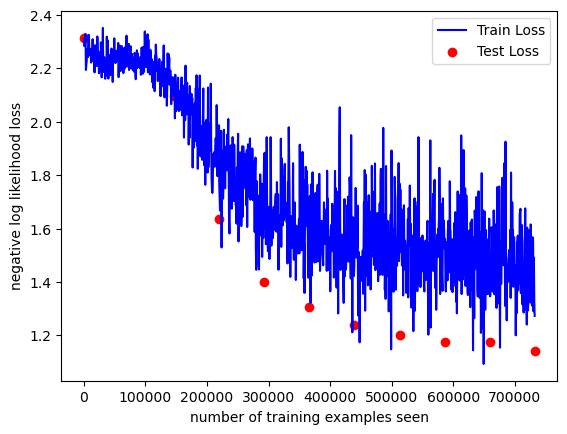

In [50]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig
plt.show()

In [13]:
with torch.no_grad():
  output = network(example_data)

/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_10407/235829359.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


/var/folders/qk/jzp1dyc171z0g769tv6jxkwm0000gn/T/ipykernel_10407/2502561851.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


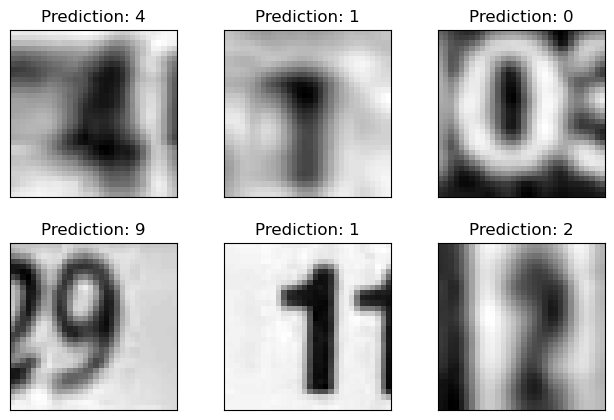

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig
plt.show()